In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/') #MAc
#sys.path.append('/home/ryuho/anaconda3/envs/smrai_env') #Laptop
sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [2]:
NH_path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5min.dat' #Server
SH_path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/fbig5minss.dat' #Server


def open_and_format(file_path):
    with open (file_path) as f:
        rectype = np.dtype(np.float32)
        reppu_data = np.fromfile(f, rectype) #size = 109,900,800
    mhd_data = pd.read_csv('mhd_dates.csv')
    expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
            for start, end in zip(mhd_data['start'], mhd_data['end'])]) 
    data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 
    return data_reshaped, expanded_dt

NH_reshaped, NH_dt = open_and_format(NH_path)
SH_reshaped, SH_dt = open_and_format(SH_path)

In [46]:

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in NH_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'NH_current': (['dt', 'lat', 'lon'], NH_reshaped.reshape(-1, 30, 80)),
                'SH_current': (['dt', 'lat', 'lon'], SH_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add current and units
ds['NH_current'].attrs['units'] = 'mA/m^2'
ds['SH_current'].attrs['units'] = 'mA/m^2'
ds['NH_current'] = ds['NH_current'] * 1e6 #convert to mA/m^2
ds['SH_current'] = ds['SH_current'] * 1e6 #convert to mA/m^2


#diff
ds['diff'] = np.abs(ds['NH_current']) - np.abs(ds['SH_current'])
ds


<xarray.Dataset> Size: 1GB
Dimensions:     (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt          (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat         (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon         (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    NH_current  (dt, lat, lon) float32 440MB 0.0 0.0 0.0 ... 0.1782 0.1768
    SH_current  (dt, lat, lon) float32 440MB 0.01009 0.01013 0.01018 ... 0.0 0.0
    diff        (dt, lat, lon) float32 440MB -0.01009 -0.01013 ... 0.1782 0.1768

In [4]:
NH_current = ds['NH_current'].values.flatten()
SH_current = ds['SH_current'].values.flatten()

NH_current_sample = NH_current[np.random.choice(NH_current.shape[0], 10000, replace=False)]
SH_current_sample = SH_current[np.random.choice(SH_current.shape[0], 10000, replace=False)]

In [83]:
#add to df then melt to plot with category of NH SH
df = pd.DataFrame({'current': np.concatenate([NH_current, SH_current]),
                   'Hemisphere': ['NH']*NH_current.shape[0] + ['SH']*SH_current.shape[0]})
df = df.melt(value_vars=['current'], id_vars=['Hemisphere'])
df

,Hemisphere,variable,value
0,NH,current,0.0
1,NH,current,0.0
2,NH,current,0.0
3,NH,current,0.0
4,NH,current,0.0
...,...,...,...
219801595,SH,current,0.0
219801596,SH,current,0.0
219801597,SH,current,0.0
219801598,SH,current,0.0


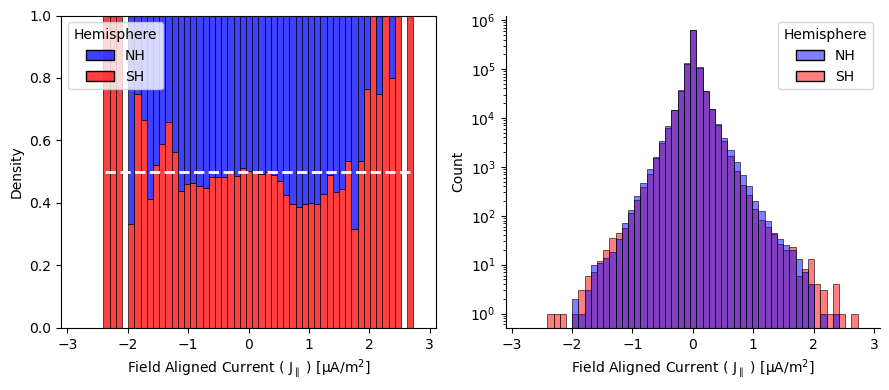

In [34]:
fig, ax = plt.subplots(1,2, figsize=(9, 4))
sns.histplot(data=df, x='value', hue='Hemisphere', bins = 50, ax=ax[0], multiple='fill', element='bars', palette=['blue', 'red'])
ax[0].set_xlim(-3.1, 3.1)
ma_unit = r'$\mathrm{\mu}$A/m$^2$'
jpar = r'J$_{\parallel}$'
ax[0].set_xlabel(f'Field Aligned Current ( {jpar} ) [{ma_unit}]')
ax[0].set_ylabel('Density')
ax[0].axhline(y=0.5, color='white', linestyle='--', linewidth=2)

sns.histplot(data=df, x='value', hue='Hemisphere', bins = 50, ax=ax[1], multiple='layer', element='bars', palette=['blue', 'red'])
ax[1].set_yscale('log')
ax[1].set_xlabel(f'Field Aligned Current ( {jpar} ) [{ma_unit}]')
ax[1].set_xlim(-3.1, 3.1)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('REPPU_NH_SH_current_asymmetry_hist_full.png', dpi=500)

In [84]:
ds['diff'].values.mean(axis=0).shape

(30, 80)

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_58944/4274620966.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18,


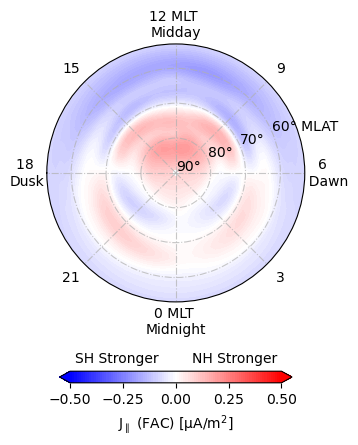

In [94]:
fac = ds['diff'].values.mean(axis=0)

#fac = fac.reshape(24, 50).T # reshape and transpose
#fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 80) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(53, 89, 30) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-.5, .5, 100), extend='both')
ax.set_ylim([0,37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{dt}", pad=10, fontsize=11.5)

#add text above colorbar
ax.text(0.73, -0.22, 'NH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
ax.text(0.27, -0.22, 'SH Stronger', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)

plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.5, pad = 0.18, 
             ticks=[-.5, -.25, 0, 0.25, 0.5], 
             orientation='horizontal')

plt.savefig('REPPU_NH_SH_current_asymmetry_radar.png', dpi=500, bbox_inches='tight')